https://kr.investing.com/commodities/zinc-futures

In [13]:
import warnings
import matplotlib
import sys
warnings.filterwarnings(action='ignore')
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [14]:
import pandas as pd
df = pd.read_csv('아연 선물 과거 데이터.csv', parse_dates=['날짜'], index_col="날짜", thousands=",") # 구분자 제거
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-04-01,2873.13,2857.88,2876.27,2851.27,NaN,0.62%
2025-03-31,2855.40,2864.83,2867.08,2827.85,NaN,0.00%
2025-03-28,2855.50,2901.15,2904.30,2855.33,NaN,-1.46%
2025-03-27,2897.93,2960.20,2960.90,2897.50,NaN,-1.96%
2025-03-26,2955.93,2972.00,2976.20,2939.45,NaN,-0.54%


In [15]:
df.shape

(2549, 6)

In [16]:
df.isna().sum()

,0
종가,0
시가,0
고가,0
저가,0
거래량,268
변동 %,0


In [17]:
(268/2549)*100 # 결측치 10% → 삭제

10.513927030207924

In [18]:
df.dropna(inplace=True)

In [19]:
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-01-14,2862.5,2875.0,2870.0,2872.0,34.79K,-0.10%
2025-01-13,2865.5,2890.0,2886.0,2886.0,31.85K,-0.09%
2025-01-10,2868.0,2893.0,2894.0,2893.0,33.90K,0.70%
2025-01-09,2848.0,2856.0,2854.0,2856.0,36.98K,0.81%
2025-01-08,2825.0,2838.0,2838.0,2838.0,48.17K,-1.76%


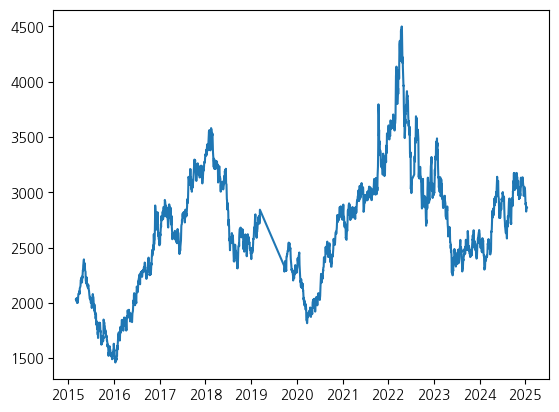

In [20]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['종가'].values)

```py
from matplotlib import pyplot as plt
df['종가'].plot(kind='line', figsize=(8, 4), title='종가') # 선 그래프
plt.gca().spines[['top', 'right']].set_visible(False)
```

plt.gca() : 현재의 그래프 축(Axes)을 가져오는 함수

.spines[['top', 'right']] : 상단(top)과 우측(right) 테두리를 선택

.set_visible(False) : 선택한 테두리를 숨김

In [21]:
df.describe()

,종가,시가,고가,저가
count,2281.000000,2281.000000,2281.000000,2281.000000
mean,2662.937966,2662.929307,2679.293029,2645.440684
std,538.703315,540.423870,535.659789,543.264043
min,1460.500000,1464.000000,1476.500000,1444.000000
25%,2317.500000,2318.000000,2332.000000,2301.000000
50%,2649.500000,2650.000000,2670.500000,2626.000000
75%,3015.000000,3017.000000,3027.250000,3000.000000
max,4498.500000,4460.000000,4458.000000,4460.000000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2281 entries, 2025-01-14 to 2015-03-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      2281 non-null   float64
 1   시가      2281 non-null   float64
 2   고가      2281 non-null   float64
 3   저가      2281 non-null   float64
 4   거래량     2281 non-null   object 
 5   변동 %    2281 non-null   object 
dtypes: float64(4), object(2)
memory usage: 124.7+ KB


                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                 1824
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9583.593
Date:                Thu, 03 Apr 2025   AIC                          19173.185
Time:                        04:55:25   BIC                          19189.710
Sample:                             0   HQIC                         19179.281
                               - 1824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2882      0.659      0.437      0.662      -1.003       1.580
ma.L1         -0.2650      0.665     -0.398      0.690      -1.568       1.038
sigma2      2160.7206     29.700     72.751      0.0

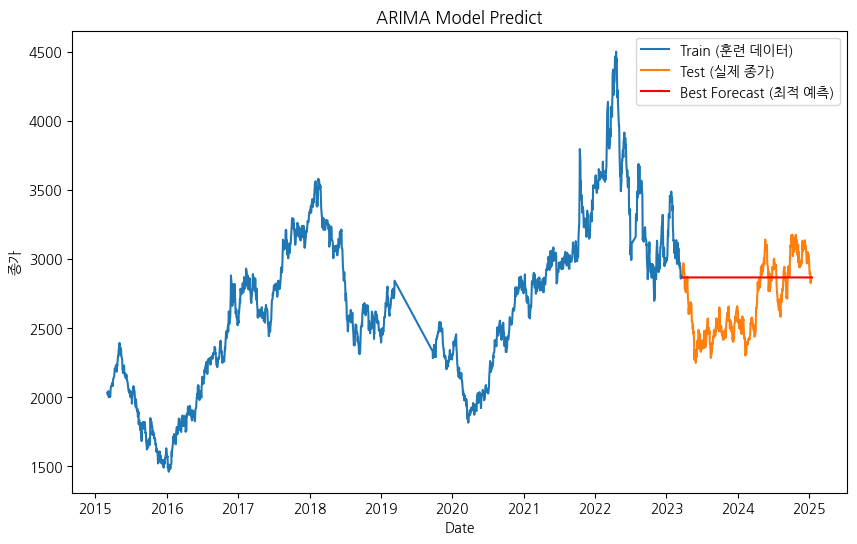

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 및 전처리
df = df.sort_index()  # 날짜 순서대로 정렬
closing_prices = df['종가']

# 훈련과 테스트 세트 분할 (80%, 20%)
split_index = int(len(closing_prices) * 0.8)
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

# ARIMA 모델 구성 및 학습
# order=(p, d, q)에서 d=1로 차분을 수행해 비정상성을 제거하고, p와 q는 (1,1) 사용
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# 테스트 기간에 대한 예측 (예측 스텝 수는 테스트 세트 길이와 동일)
forecast = model_fit.forecast(steps=len(test))

# 예측 성능 평가 (평균 제곱 오차)
mse = mean_squared_error(test, forecast)
print("Mean Squared Error:", mse)

# 실제 종가와 예측 종가 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train (훈련 데이터)')
plt.plot(test.index, test, label='Test (실제 종가)')
plt.plot(test.index, forecast, label='Best Forecast (최적 예측)', color='red')
plt.title("ARIMA Model Predict")
plt.xlabel("Date")
plt.ylabel("종가")
plt.legend()
plt.show()

order=(1,1,1) → MSE: 95889.84764434768
order=(1,1,2) → MSE: 102767.1893511485
order=(1,2,1) → MSE: 126736.91229933627
order=(1,2,2) → MSE: 126145.60414760525
order=(2,1,1) → MSE: 95925.17010691517
order=(2,1,2) → MSE: 88698.01736202666
order=(2,2,1) → MSE: 126998.8059470845
order=(2,2,2) → MSE: 126357.91709488716

최적의 order 값: (np.int64(2), np.int64(1), np.int64(2)), 최소 MSE: 88698.01736202666


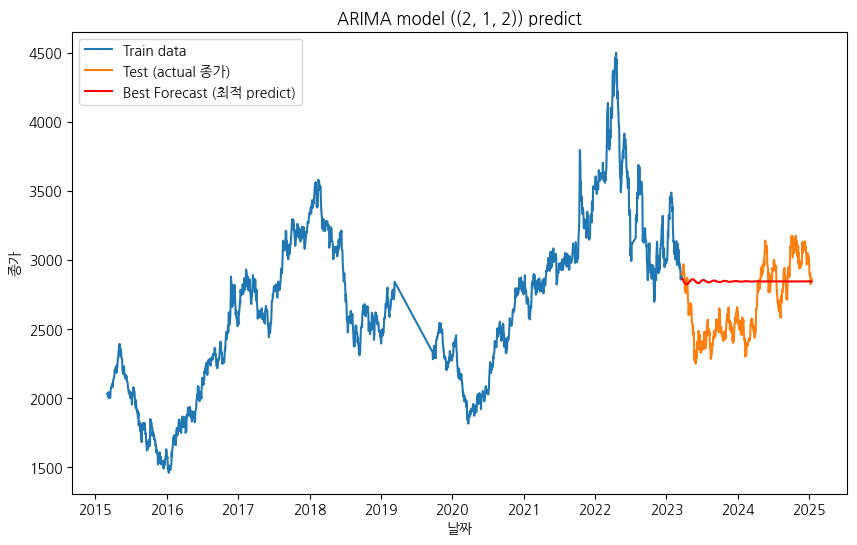

In [24]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 및 정렬
df = df.sort_index()
closing_prices = df['종가']

# 훈련과 테스트 세트 분할
split_index = int(len(closing_prices) * 0.8)
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

# p, d, q의 조합 생성 (1~2 범위 지정)
p_range = np.arange(1, 3)  # [1, 2]
d_range = np.arange(1, 3)  # [1, 2]
q_range = np.arange(1, 3)  # [1, 2]
best_mse = float("inf") # 양의 무한대
best_order = None

# 모든 조합에 대해 반복 실행
for p, d, q in itertools.product(p_range, d_range, q_range): # 모든 조합을 하나씩 순회하며 사용(데카르트 곱)
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)

        # 더 낮은 MSE를 찾으면 갱신(MSE는 오차가 작을수록 모델의 예측이 실제 데이터에 더 잘 맞는 것을 의미)
        if mse < best_mse:
            best_mse = mse
            best_order = (p, d, q)

        print(f"order=({p},{d},{q}) → MSE: {mse}")

    except Exception as e:
        print(f"order=({p},{d},{q})에서 오류 발생: {e}")

print(f"\n최적의 order 값: {best_order}, 최소 MSE: {best_mse}")

# 최적 모델 학습
best_model = ARIMA(train, order=best_order)
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=len(test))

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train data')
plt.plot(test.index, test, label='Test (actual 종가)')
plt.plot(test.index, best_forecast, label='Best Forecast (최적 predict)', color='red')
plt.title(f"ARIMA model ({tuple(map(int, best_order))}) predict")
plt.xlabel("날짜")
plt.ylabel("종가")
plt.legend()
plt.show()
